# Exploratory Data Analysis - US Warehouses

<p><a name="sections"></a></p>


## Sections

- <a href="#preprocess">Preprocessing \& Enrichment </a><br>
 - <a href="#clean">Cleaning</a><br>
 - <a href="#readin">Read in External Datasets</a><br>
   - <a href="#cities">Latitude and Longitude : Cities</a><br>
   - <a href="#airports">Latitude and Longitude : Airports</a><br>
   - <a href="#ports">Latitude and Longitude : Ports</a><br>
   - <a href="#regions">Regional Assignments</a><br>
   - <a href="#merge1">Merge Location Information</a><br>
 - <a href="#createtrans">Create Transport Dictionary</a><br>
    - <a href="#transAnalysis">City Transport Analysis</a><br>
 - <a href="#cityprice">Aggregation: City Level</a><br>
     - <a href="#outlier1">Outlier Analysis</a><br>
     - <a href="#merge2">Merge with Transport Dataframe</a><br>
 - <a href="#connectivity">Connectivity Metric</a><br>
 - <a href="#connect+">Connect+ Metric</a><br>
- <a href="#visual">Analysis</a><br>
 - <a href="#city_vis">Visualization of US Warehouse Distribution by Cities</a><br>
 - <a href="#tristate">NY Metro Case Study</a><br>
    - <a href="#nylease">Lease Rates Across Different Sizes</a><br>
 - <a href="#statelevel">State Level Analysis</a><br>
 - <a href="#correlation">Correlation Dashboard</a><br>

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
from clean import *
pd.set_option('display.max_columns', 50)

<p><a name="preprocess"></a></p>

## Preprocessing

Write all csv files in the data folder to text file in current directory

In [4]:
!ls ./data > data.txt

#### Read in data.txt and create dataframe df from raw data

In [5]:
with open('data.txt','r') as f:
    lines = f.readlines()

data = []   
for line in lines:
    data.append(pd.read_csv('./data/'+line[:-1]))

df_raw = pd.concat(data)

<p><a name="clean"></a></p>

### Cleaning

Clean and generate new columns with clean.py and export cleaned data to csv

In [6]:
df = clean(df_raw)
df = df.dropna(subset=['price'])
df.shape

(9217, 16)

<p><a name="readin"></a></p>

### Read in External Datasets

Read in external datasets for richer data analysis and exploration

<p><a name="cities"></a></p>

#### Latitude and Longitude: Cities

In [7]:
latlon = pd.read_csv('./extra-data/us-zip-geom.csv', 
                     header=0, 
                     names = ['city','state','lat','lon'],
                     usecols = [1,2,3,4],
                    index_col=False)

# Artifact from cities with multiple zipcodes. 
latlon = latlon.drop_duplicates(subset=['city'])

In [8]:
latlon[latlon.city=='Brookfield']

city state        lat       lon
356  Brookfield    OH  41.239987 -80.58346

<p><a name="airports"></a></p>

#### Latitude and Longitude: Airports

Read in airport dataset. I'll only use large and medium sized airports, ignoring small private airfields and heliports that are not usually considered for most supply chain analyses


In [9]:
airports = pd.read_csv('./extra-data/us-airports.csv')
airports = airports[airports['type'].isin(['large_airport','medium_airport'])]
airports = airports[['type','name','latitude_deg','longitude_deg','iso_region']]
airports['iso_region'] = airports['iso_region'].apply(lambda x: x[-2:])
airports.columns = ['type','name','lat','lon','state']
airports.dropna(inplace=True)
airports = airports[:300]

In [10]:
airports.sample()

type                        name        lat        lon state
133  large_airport  Asheville Regional Airport  35.436199 -82.541801    NC

<p><a name="ports"></a></p>

#### Latitude and Longitude: Ports

Read in port dataset. Select for US ports.

In [11]:
ports = pd.read_json('./extra-data/ports.json', orient='index')
ports = ports[['name','coordinates','city','province','country']]

ports = ports[ports.country=='United States']
ports = ports.reset_index()

tags = ports['coordinates'].apply(pd.Series)
ports = pd.concat([ports,tags],axis=1)
ports = ports.drop(['index','city','country','coordinates'], axis=1)
ports.columns = ['name','state','lon','lat']
ports.dropna(inplace=True)
ports['name'] += ' Port'

In [12]:
ports.sample()

name     state      lon        lat
28  Decatur Port  Illinois -88.9548  39.840315

<p><a name="regions"></a></p>

#### Regional Assignments

Read in regional and divisional assignments for each state according to the US Census Bureau

In [13]:
regions = pd.read_csv('./extra-data/states.csv')

<p><a name="merge1"></a></p>

#### Merge Location Information

Merge warehouse data with city level latitude and longitude data and regional assignments on the state level. 

In [14]:
df_ = pd.merge(df, latlon, on=['city','state'], how='left')
df = pd.merge(df_,regions[['State Code','Region','Division']], how='left',left_on='state',right_on='State Code')
df.drop(columns = ['State Code'], inplace=True)

In [15]:
df['spaceClass'] = pd.cut(df['spaceAvailable'], bins=[0,5e4,1.5e5,1e8], labels=['small','medium','large'])

In [16]:
df['spaceClass'].value_counts()

small     7828
medium    1028
large      361
Name: spaceClass, dtype: int64

In [17]:
df.sample()

address  buildingSize        city  \
5388  3307 Gilmore Industrial Blvd Louisville, KY       12000.0  Louisville   

     listingDate  price    propType  spaceAvailable  spaces state     subType  \
5388  2020-03-06   0.65  Industrial           12000       1    KY  Industrial   

                                              transport utilities  yearBuilt  \
5388  {'Louisville International Airport': [6.9, 14....        []       1992   

      yearRenovated                                           propInfo  \
5388           1992    lease rate does not include certain property...   

      ceilingHeight        lat        lon Region            Division  \
5388             16  38.188962 -85.676819  South  East South Central   

     spaceClass  
5388      small

<p><a name="createtrans"></a></p>

### Create Transport Hub Dataframe

For all transportation connections pulled in from the listing, I aggregate the speedOfTravel (calculated by dividing the distance by time (converted to hours) to get an estimated measure of traffic/congestion in that area.

<img src="./pics/transport_example.png">

In [18]:
# Create an empty list to house the extracted values
lst = []
# Enumerate for every dictionary entry in the transport column
for i,dic in enumerate(df.transport):
    state, city, lat,lon = df.iloc[i][['state','city','lat','lon']]
    city = city + ', ' + state
    for k,v in dic.items():
        lst.append([i, state, city, lat,lon, k, *v])

transport_df = pd.DataFrame(lst, columns=['index','state','city','lat','lon', 'name','distance','timeTo','speedOfTravel'])

The new dataframe, **transport_df**, preserves the index of the entry it's tied to in the original dataframe, **df**

\*Note\* In this case the geom point corresponds to the city not the 'name' of the transportation hub

In [19]:
transport_df.head(5)

index state            city        lat       lon  \
0      0    NC   Charlotte, NC  35.248292 -80.82748   
1      0    NC   Charlotte, NC  35.248292 -80.82748   
2      0    NC   Charlotte, NC  35.248292 -80.82748   
3      1    NC  Greensboro, NC        NaN       NaN   
4      1    NC  Greensboro, NC        NaN       NaN   

                                                name  distance  timeTo  \
0            Charlotte Douglas International Airport       8.7    20.0   
1                                 Port of Wilmington     205.6   244.0   
2  NS THOROUGHBRED BULK TRANSFER TERMINAL-CHARLOT...       0.5     2.0   
3               Piedmont Triad International Airport       9.7    20.0   
4                 Virginia Port Authority - Richmond     206.8   241.0   

   speedOfTravel  
0           26.1  
1           50.6  
2           15.0  
3           29.1  
4           51.5

Create a new dataframe for the average traffic in each city. 

This dataset contains many cities containing only one warehouse. While at first glance this could be seen to present a problem - I make the following assumptions to justify aggregation by mean for a traffic metric:

1. Cities with few warehouse listings probably don't have much traffic regularly and so one or two datapoints isn't a problem.

2. One warehouse can have multiple entries for nearby transport hubs, allowing for a better sense of local traffic even with a single listing.

3. Information is self reported by each realtor, to market the listing attractively and include as many relevant hubs as possible. 

In [20]:
traffic_city = transport_df.groupby(['city','state','lat','lon']).agg({'city': 'count',
                                                   'distance': 'mean',
                                                   'timeTo' : 'mean',
                                                   'speedOfTravel': 'mean'}).round(0)
traffic_city.columns = ['datapoints','distance','time','speed']
traffic_city = traffic_city.reset_index()

In [21]:
traffic_city.to_csv('city_traffic.csv')

In [22]:
df.drop(columns=['transport'], inplace=True)
df.to_csv('data_cleaned.csv')
df.shape

(9217, 20)

In [23]:
df.sample()

address  buildingSize     city listingDate  price  \
89  37 Elkay Dr Chester, NY       22500.0  Chester  2019-07-29   0.67   

      propType  spaceAvailable  spaces state     subType utilities  yearBuilt  \
89  Industrial           17500       1    NY  Industrial        []       2003   

    yearRenovated                                           propInfo  \
89           2003   -mercury vapor lighting in warehouse area; fl...   

    ceilingHeight  lat  lon     Region         Division spaceClass  
89             16  NaN  NaN  Northeast  Middle Atlantic      small

All calculated values are averages. 

Average distance is in miles.

Average travel time to nearest transportation (airport, freight port, railroad, etc.) is in minutes. 

Average speed is in MPH. (Calculated in the clean.py file)

All values rounded to nearest unit. 

In [24]:
traffic_city.sample(2)

city state        lat       lon  datapoints  distance  time  \
439  Greenville, SC    SC  34.825592 -82.34099          93      73.0  90.0   
985  Saint Rose, LA    LA  29.962601 -90.30965          15       8.0  15.0   

     speed  
439   33.0  
985   26.0

<p><a name="transAnalysis"></a></p>

#### City Transport Analysis

Now, lets look for cities with an average speed over 3 standard deviations away. 

In [25]:
from scipy import stats
traffic_city[np.abs(stats.zscore(traffic_city[['speed']]) > 3).all(axis=1)]

city state        lat        lon  datapoints  distance   time  \
402  Gillette, WY    WY  43.939968 -105.52445           3     113.0  120.0   

     speed  
402   57.0

Basically none! I had a problem earlier with calculated speeds of over 1000 MPH and the problem was many listings had travel time information that simply did not agree with the capabilites of modern automotive engineering. It turned out my assumption of realtor honesty was slightly misplaced. There's no way you can go 20 miles in one minute. I cleaned up that problem in clean.py where I set a maximum speed limit of 75MPH.

<img src="./pics/crazySpeed.png">

<p><a name="cityprice"></a></p>

### Aggregation: City Level

Aggregate listings by cities, counting the number of warehouses in each city, and taking the mean or median values of various features. 

In [26]:
# Rename city column to account for shared city names among states
df['city'] = df['city'] + ', ' + df['state']
price_df = df.groupby(['city','state','Region','Division']).agg({'address' : 'count',
                         'price' : 'mean',
                         'spaceAvailable' : 'mean',
                         'buildingSize' : 'mean',
                         'yearBuilt' : 'median',
                         'yearRenovated' : 'median'
                         })

price_df = price_df.reset_index()
price_df.columns = ['city','state','region','division',\
                    'warehouses','price','leaseSpace',\
                    'buildingSize','yearBuilt','yearRenovated']

price_df.price = price_df.price.round(2)
price_df.leaseSpace = price_df.leaseSpace.round(-2) # round to nearest 100
price_df.buildingSize = price_df.buildingSize.round(-2)
price_df.yearBuilt = price_df.yearBuilt.astype(int)
price_df.yearRenovated = price_df.yearRenovated.astype(int)

In [27]:
price_df.sample(2)

city state     region         division  warehouses  price  \
1995  Sanford, NC    NC      South   South Atlantic           3   0.34   
1841   Rahway, NJ    NJ  Northeast  Middle Atlantic           1   0.68   

      leaseSpace  buildingSize  yearBuilt  yearRenovated  
1995    123300.0      136200.0       1996           2000  
1841     15000.0      297000.0       1932           1932

<p><a name="outlier1"></a></p>

#### Outlier Analysis

Plenty of outliers in this set. 

Takeaway: New York and LA real estate is very expensive. And Newark Ohio too

In [28]:
price_df[np.abs(stats.zscore(price_df[['price']]) > 4).all(axis=1)]

city state     region            division  warehouses  \
752        Flushing, NY    NY  Northeast     Middle Atlantic           3   
1511  Mountain View, CA    CA       West             Pacific           2   
1556      New Lenox, IL    IL    Midwest  East North Central           4   
1567       New York, NY    NY  Northeast     Middle Atlantic           2   
1570         Newark, OH    OH    Midwest  East North Central           1   
1702      Palo Alto, CA    CA       West             Pacific           1   
1999   Santa Monica, CA    CA       West             Pacific           3   
2242         Tunica, MS    MS      South  East South Central           1   
2468        Woodway, TX    TX      South  West South Central           2   

      price  leaseSpace  buildingSize  yearBuilt  yearRenovated  
752    2.64      3900.0      148700.0       1949           1949  
1511   2.92      5100.0       12100.0       1970           1970  
1556   3.54      1900.0       42000.0       1993           1993  
1567   5.44      1700.0       14500.0       1976           1976  
1570  11.85     20000.0      172100.0       1954           1954  
1702   2.75      6600.0        6600.0       1963           1963  
1999   5.08      7000.0       13000.0       1960           1960  
2242   3.00     11000.0       11000.0       1980           1980  
2468   2.91      9700.0       31900.0       1971           1971

Nothing truly unexpected except for Newark OH, so we're just going to drop that one

In [29]:
price_df = price_df.drop(labels=1570)

<p><a name="merge2"></a></p>

#### Merge with Transport Dataframe

In [30]:
mean_df = pd.merge(price_df, traffic_city, 
                   on = ['city','state'],
                   how = 'inner')


<p><a name="connectivity"></a></p>

### Connectivity Metric

Create new column for connectivity.

Connectivity is the density of connections in a given city divided by the average time (hrs) to travel to those connections.

I use this measure since it ignores traffic conditions that could affect using the average distance in the calculation. Traveling 10 miles in NYC is very different than traveling 10 miles in Alaska.

In [31]:
mean_df['hubDensity'] = mean_df['datapoints'] / mean_df['warehouses']
mean_df['connectivity'] = (mean_df['hubDensity']*60/mean_df['time']).round(2)

# Normalization
mean_df['connectivity'] /= np.max(mean_df['connectivity'],axis=0)/100
mean_df['connectivity'] = mean_df['connectivity'].round(0)

<p><a name="connect+"></a></p>

### Connect+ Metric

In [32]:
cities = mean_df[['city','lat','lon']]
cities.columns = ['name','lat','lon']

ports = ports[['name','lat','lon']]
airports = airports[['name','lat','lon']]



The following cell calculates the distance between every city, port, and airport in this notebook.

It may take a while. So I've included the data in the folder from a previous session. 

In [33]:
from wh_metrics import *

#distMatrix = distance_matrix([cities,ports,airports])
#distMatrix.to_csv('./extra-data/distances.csv')
distMatrix = pd.read_csv('./extra-data/distances.csv').drop(columns='Unnamed: 0')
distMatrix.head(5)


Abbotsford, WI  Abilene, TX  Abingdon, MD   Abrams, WI      Ada, OK  \
0        0.000000  1002.904166    808.998227   111.204134   779.276978   
1     1002.904166     0.000000   1393.291343  1060.322894   240.191915   
2      808.998227  1393.291343      0.000000   704.065660  1165.027547   
3      111.204134  1060.322894    704.065660     0.000000   828.539959   
4      779.276978   240.191915   1165.027547   828.539959     0.000000   

   Adairsville, GA  Adelanto, CA   Agawam, MA     Aiea, HI    Aiken, SC  \
0       784.715228   1599.776619   906.276134  4106.689541   907.285702   
1       863.504771   1034.696110  1624.268592  3623.318685  1050.976242   
2       592.381527   2276.687984   263.065520  4860.060420   498.736576   
3       738.751755   1703.409315   795.113289  4217.561298   842.338569   
4       667.980445   1181.976144  1389.844170  3790.122836   862.385720   

   Airway Heights, WA    Akron, OH   Albany, NY  Albert Lea, MN  \
0         1308.899874   514.992252   829.126323      176.090003   
1         1408.049431  1169.371884  1569.078440      849.690887   
2         2115.909580   298.874627   248.587889      926.549682   
3         1417.486812   414.703762   717.926665      275.013213   
4         1397.218321   931.771058  1332.828055      638.190364   

   Albuquerque, NM    Allen, KY  Allentown, PA  Alpharetta, GA   Alsip, IL  \
0      1100.535510   641.294630     805.770566      818.258398  260.613814   
1       438.924354  1024.983502    1456.504376      901.052431  918.756947   
2      1689.880957   370.276269      94.927743      576.676789  618.508598   
3      1190.346177   567.524691     697.022586      768.229325  215.670001   
4       567.321492   800.658322    1224.378002      709.244143  679.306750   

     Alvin, TX  Amarillo, TX  American Fork, UT  Amesbury, MA  Anaheim, CA  \
0  1107.016710    908.212365        1132.352871    972.701076  1652.354988   
1   336.499136    229.679536         867.653481   1721.385879  1058.288604   
2  1279.937452   1430.983398        1868.964121    363.692669  2320.459410   
3  1132.977027    984.922093        1240.728603    861.700494  1755.202541   
4   379.577367    297.055416         913.462451   1485.931319  1214.613123   

   Anamosa, IA  ...  Cedar City Regional Airport  \
0   202.418910  ...                  1278.853459   
1   814.425972  ...                   839.309177   
2   803.166347  ...                  1977.489508   
3   246.106142  ...                  1383.824801   
4   584.317691  ...                   936.796236   

   Fayetteville Regional Grannis Field  Valley International Airport  \
0                           914.413200                   1356.465669   
1                          1208.962387                    444.695622   
2                           340.701634                   1534.088412   
3                           832.084904                   1389.226691   
4                          1006.635824                    593.283214   

   Helena Regional Airport  Tweed New Haven Airport  Willow Run Airport  \
0              1047.527756               912.770815          387.188257   
1              1175.781192              1596.887810         1115.996855   
2              1850.805378               218.019963          423.256144   
3              1157.487475               802.064956          286.715018   
4              1141.875966              1364.441842          875.924726   

   Mc Minnville Municipal Airport  \
0                     1590.932235   
1                     1530.357998   
2                     2390.478230   
3                     1701.269931   
4                     1565.743372   

   Jack Northrop Field Hawthorne Municipal Airport  Chicago Executive Airport  \
0                                      1666.962066                 229.993223   
1                                      1080.186149                 932.165166   
2                                      2338.733185                 633.179067   
3                     

#### Metric: Average Distance to n Closest Neighbors

In [34]:
# Merge to get additional metric of average distance to n nearest neighbors
# in this case n = 20
neighbors = n_nearest(distMatrix, 20).round(0)
df_ = pd.merge(mean_df,neighbors[['name','mean_dist']], \
                   left_on='city',right_on='name', how='left')

#### Metric: Number of Nearest for a given Distance

In [35]:
num_near = num_nearest(distMatrix,d=30)
mean_df = pd.merge(df_,num_near[['name','num_nearest']], \
                   left_on='city',right_on='name', how='left')
mean_df.drop(columns=['name_x','name_y'], inplace=True)

In [36]:
mean_df.sample()

city state region            division  warehouses  price  \
472  Hazlehurst, MS    MS  South  East South Central           1   0.29   

     leaseSpace  buildingSize  yearBuilt  yearRenovated        lat       lon  \
472    230400.0      406200.0       2000           2000  31.841281 -90.42995   

     datapoints  distance   time  speed  hubDensity  connectivity  mean_dist  \
472           2      90.0  108.0   47.0         2.0           4.0      104.0   

     num_nearest  
472            1

#### Connect+ Calculation

In [38]:
mean_df['connect+'] = mean_df['connectivity'] + mean_df['num_nearest']
mean_df['connect+'] /= np.max(mean_df['connect+'],axis=0)/100
mean_df['connect+'] = mean_df['connect+'].round(1)

mean_df['mean_dist'] /= np.max(mean_df['mean_dist'],axis=0)/100


In [39]:
mean_df.head()

city state   region            division  warehouses  price  \
0  Abbotsford, WI    WI  Midwest  East North Central           1   0.36   
1     Abilene, TX    TX    South  West South Central           3   0.52   
2    Abingdon, MD    MD    South      South Atlantic           1   0.54   
3      Abrams, WI    WI  Midwest  East North Central           1   0.34   
4         Ada, OK    OK    South  West South Central           1   0.50   

   leaseSpace  buildingSize  yearBuilt  yearRenovated        lat        lon  \
0     17200.0       17200.0       1970           1970  44.950905 -90.304860   
1      5800.0       21900.0       1984           1984  32.407690 -99.721070   
2     60000.0       60600.0       1995           1995  39.473899 -76.298300   
3      4100.0        4100.0       1986           1986  44.788898 -88.045350   
4     60000.0       60000.0       1940           1940  34.772557 -96.661745   

   datapoints  distance   time  speed  hubDensity  connectivity  mean_dist  \
0           1      24.0   39.0   37.0         1.0           5.0   8.069164   
1           6     138.0  172.0   43.0         2.0           2.0  12.776177   
2           2       6.0   12.0   30.0         2.0          33.0   3.073967   
3           2      21.0   32.0   40.0         2.0          12.0   6.147935   
4           2     176.0  225.0   47.0         2.0           2.0   9.317963   

   num_nearest  connect+  
0            0       2.8  
1            1       1.7  
2            7      22.5  
3            3       8.4  
4            0       1.1

<p><a name="visual"></a></p>

## Analysis

In [40]:
mean_df.corr()[np.abs(df_.corr()) > 0.3]['price']

warehouses            NaN
price            1.000000
leaseSpace            NaN
buildingSize          NaN
yearBuilt             NaN
yearRenovated         NaN
lat                   NaN
lon                   NaN
datapoints            NaN
distance              NaN
time                  NaN
speed                 NaN
hubDensity       0.348794
connectivity     0.440953
mean_dist             NaN
num_nearest           NaN
connect+              NaN
Name: price, dtype: float64

After so much effort, the connect+ metric only improves on connectivity as a metric to gauge price by 0.02.

### Visualization

In [41]:
mean_df.head()

city state   region            division  warehouses  price  \
0  Abbotsford, WI    WI  Midwest  East North Central           1   0.36   
1     Abilene, TX    TX    South  West South Central           3   0.52   
2    Abingdon, MD    MD    South      South Atlantic           1   0.54   
3      Abrams, WI    WI  Midwest  East North Central           1   0.34   
4         Ada, OK    OK    South  West South Central           1   0.50   

   leaseSpace  buildingSize  yearBuilt  yearRenovated        lat        lon  \
0     17200.0       17200.0       1970           1970  44.950905 -90.304860   
1      5800.0       21900.0       1984           1984  32.407690 -99.721070   
2     60000.0       60600.0       1995           1995  39.473899 -76.298300   
3      4100.0        4100.0       1986           1986  44.788898 -88.045350   
4     60000.0       60000.0       1940           1940  34.772557 -96.661745   

   datapoints  distance   time  speed  hubDensity  connectivity  mean_dist  \
0           1      24.0   39.0   37.0         1.0           5.0   8.069164   
1           6     138.0  172.0   43.0         2.0           2.0  12.776177   
2           2       6.0   12.0   30.0         2.0          33.0   3.073967   
3           2      21.0   32.0   40.0         2.0          12.0   6.147935   
4           2     176.0  225.0   47.0         2.0           2.0   9.317963   

   num_nearest  connect+  
0            0       2.8  
1            1       1.7  
2            7      22.5  
3            3       8.4  
4            0       1.1

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [43]:
my_order

NameError: name 'my_order' is not defined

In [49]:
nymica = mean_df[mean_df.state.isin(['NY','MI','CA','NJ','FL','HI'])] 
my_order = nymica.groupby('state')['connectivity'].median().sort_values().index


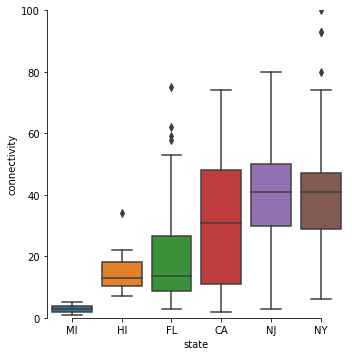

In [51]:
g = sns.catplot(y="connectivity", x="state", kind="box",
                legend=False, data=nymica, order=my_order)
#g.add_legend(title="Meal")
#g.set_axis_labels("Total bill ($)", "")
g.set(ylim=(0, 100))#, yscale='log')
g.despine(trim=True)
#g.fig.set_size_inches(6.5, 3.5)
#g.ax.set_xticks([5, 15, 25, 35, 45, 55], minor=True);
#plt.setp(g.ax.get_yticklabels(), rotation=30);

In [143]:
import chart_studio
import chart_studio.plotly as py
import plotly.express as px
import chart_studio.tools as tls
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator
username = 'snuzbrokh'
key = 'VO2VYRrTv3I0uWHHkUpX'

chart_studio.tools.set_credentials_file(username=username, api_key=key)

<p><a name="city_vis"></a></p>

### National Distribution on City Level

The following is a visualization of the nationwide distribution of warehouses. The location is approximated by the corresponding city coordinates. 

Each "city" is then sorted according to the average rate at which industrial warehouse space is leased. 

The visualization also sizes each city according to the value of the "connectivity" metric I calculated earlier. Cities with higher connectivity have larger circles and ones with lower connectivity have smaller radii. 

Hovering over each circle also reveals the calculated averages for various features of the warehouses in that city: 
- Average distance to the hub (how many miles to the freight port)
- Average time to the hub (how much time to the freight port)
- Average price per square foot
- Median square footage of lease space
- Connectivity of the city

In [144]:
bins = ['very cheap','cheap','average','expensive','very expensive','obscene']
mean_df['priceClass'] = pd.cut(mean_df['price'],bins=[0,0.5,0.8,1.2,1.7,2.5,6.0],labels=bins)

In [145]:
mean_df['mean_dist']=mean_df['mean_dist'].round(1)

In [146]:
df_ = mean_df.copy()

for col in df_.columns:
    df_[col] = df_[col].astype(str)
    
df_['text'] = df_['city'] + \
              '<br>Distance to Hub: ' + df_['distance'] + ' mi'\
              '<br>Time to Hub: ' + df_['time'] + ' min' +\
              '\n<br>Price per SF: $' + df_['price'] + \
              '<br>Square Footage: ' + df_['leaseSpace'] + ' SF' +\
              '<br>Connectivity: ' + df_['connectivity']

colors = ["darkgreen","purple","crimson","lightseagreen","orange","yellow"]
colors = dict(zip(bins[::-1],colors))
cities = []
scale = 2

# Too many airports for a good visualization
airports = airports[:300]

In [147]:
priceClasses = df_.groupby('priceClass')


fig = go.Figure()

for priceClass,group in priceClasses:
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = group['lon'].astype(float),
        lat = group['lat'].astype(float),
        text = group['text'],
        marker = dict(
            size = group['connect+'].astype(float)*scale,
            color = colors[priceClass],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = f'{priceClass}'))

# Add in port locations
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = ports['lon'].astype(float),
    lat = ports['lat'].astype(float),
    visible='legendonly',
    text = ports['name'],
    marker = dict(
        size = 6,
        color = 'white',
        line_color = 'rgb(0,0,0)',
        line_width = 1,
        sizemode = 'area'
    ),
    name = 'Ports'))

# Add in airport locations
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = airports['lon'].astype(float),
    lat = airports['lat'].astype(float),
    visible='legendonly',
    text = airports['name'],
    marker = dict(
        size = 7,
        color = 'white',
        line_color = 'blue',
        line_width = 2,
        symbol = 219
    ),
    name = 'Airports'))
fig.update_geos(
    resolution=50,
    showrivers=True, rivercolor="Blue"
)
# Add range indicators
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_['lon'].astype(float),
    lat = df_['lat'].astype(float),
    text = df_['mean_dist'],
    visible='legendonly',
    #transforms = [{ type: "groupby", groups: df_['region'] }],
    marker = dict(
        size = df_['distance'].astype(float),
        color = 'rgba(17, 157, 255,0.2)',
        line = dict(
            color = 'rgb(0,0,0)',
            width = 1,
        ),
        sizemode = 'area'
    ),
    name = 'Transport Length'))

fig.update_layout(
        title_text = 'Warehouse Connectivity by City \
        <br>(Click legend to toggle traces sorted by price)',
        showlegend = True,
        hovermode = 'closest',
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

#### Export Visualization to Plotly

The link below offers a much better user experience for viewing the visualization

In [148]:
py.plot(fig, 
        filename = "city warehouses bubble graph", 
        auto_open = False)

'https://plotly.com/~snuzbrokh/34/'

<p><a name="tristate"></a></p>

### NY Metro Case Study

The New York metropolitan area is the largest metropolitan area in the world by physical size. The metropolitan area includes New York City (the most populous city in the United States), Long Island, and the Mid and Lower Hudson Valley in the state of New York; the five largest cities in New Jersey: Newark, Jersey City, Paterson, Elizabeth, and Edison, and their vicinities; and six of the seven largest cities in Connecticut: Bridgeport, New Haven, Stamford, Waterbury, Norwalk, and Danbury, and their vicinities.

For our purposes we will look at all the warehouses in the 4 state region. 


<p><a name="nylease"></a></p>

#### Distribution of Lease Rates Across Sizes

In [149]:
# Take out outliers like expensive and small warehouse space in Manhattan
df_ = mean_df[mean_df.state.isin(['NY','NJ','CT','PA'])]
nymetro = df_[np.abs(stats.zscore(df_[['price']]) < 3).all(axis=1)]
nymetro['spaceClass'] = pd.cut(nymetro['leaseSpace'], bins=[0,5e4,2e5,1e8], labels=['small','medium','large'])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [150]:
fig = go.Figure()

fig = px.scatter(nymetro, x='connect+', y='price',facet_col='spaceClass',color='state', hover_data=['city'],size='mean_dist',trendline='ols')
fig.show()

In [151]:
py.plot(fig, 
        filename = "price across sizes", 
        auto_open = False)

'https://plotly.com/~snuzbrokh/65/'

### Scatter Matrix

In [152]:
import pandas as pd
from sklearn import preprocessing
columns = ['price','leaseSpace','lat','lon','distance','time','speed','connectivity','hubDensity']
df_ = mean_df[columns]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_)
df_ = pd.DataFrame(x_scaled, columns = columns)

In [153]:
fig = px.scatter_matrix(nymetro, dimensions=['leaseSpace','connect+','num_nearest','price'], color='state')
fig.show()

<p><a name="statelevel"></a></p>

### State Level Indicators
Here we group on the state level to get similar indications of average speed, distance, and time. It is hoped such data is also useful since most transport hubs are by definition linked to others in the state itself and nearby ones. Another assumption I make is that such networks have been optimzied nationwide so I expect to see not much variation between states in these numbers. 

In [96]:
state_df = mean_df.groupby(['state','region','division']).agg({'city': 'count',
                                                'price' : 'mean',
                                                'leaseSpace' : 'median',
                                                'buildingSize' : 'median',
                                                'yearBuilt' : 'median',
                                                'yearRenovated' : 'median',
                                                'lat' : 'mean',
                                                'lon' : 'mean',
                                                'distance': 'mean',
                                                'time' : 'mean',
                                                'connectivity':'mean',
                                                'connect+' : 'mean',
                                                'hubDensity' : 'mean'})
state_df = state_df.reset_index()
state_df.price = state_df.price.round(2)
state_df.leaseSpace = state_df.leaseSpace.round(-2).astype(int) # round to nearest 100
state_df.buildingSize = state_df.buildingSize.round(-2).astype(int)
state_df.yearBuilt = state_df.yearBuilt.astype(int)
state_df.yearRenovated = state_df.yearRenovated.astype(int)
state_df.connectivity = state_df.connectivity.round(2)
state_df.hubDensity = state_df.hubDensity.round(1)
state_df.distance = state_df.distance.round(0)
state_df.time = state_df.time.round(0)


Outliers on connectivity at the state level:

In [97]:
state_df[np.abs(stats.zscore(state_df[['connectivity']]) > 2).all(axis=1)]

state     region         division  city  price  leaseSpace  buildingSize  \
30    NJ  Northeast  Middle Atlantic    67   0.83       19000         56800   
33    NY  Northeast  Middle Atlantic    60   1.28       13200         37100   

    yearBuilt  yearRenovated        lat        lon  distance  time  \
30       1972           1978  40.555634 -74.391213      16.0  26.0   
33       1968           1969  41.115065 -73.750487      20.0  29.0   

    connectivity   connect+  hubDensity  
30         40.48  52.171642         4.7  
33         40.23  47.760000         4.9

<p><a name="correlation"></a></p>

### Correlation Dashboard

Here I separate out each factor's correlation with price by state. I do this to get a sense of how each feature varies from state to state. 


In [52]:
def findInfluence(df, target, feature, subset):
    '''
    Takes in a dataframe, the target, the feature of interest,
    and the subset of the feature of interest. 
    
    Filters the dataframe to all rows whose feature lies in that
    subset. 
    
    Calculates and returns the correlation of filtered dataframe. 
    '''
    
    data = df[df[feature].isin(subset)]
    cor = data.corr()
    return cor[target]

In [53]:
df_ = mean_df.copy()

states = df_.groupby(['state'])
data = pd.DataFrame()

# For each state, calculate the price correlation among all its features
for state,group in states:
    data[state] = findInfluence(group,'price','state',[state])
    
# Transpose the data indexed by states and round all values to 2 decimal places
data = data.T.round(2)



Crosstab the original dataframe of listings to sort by SpaceClass. This will give a handle as to how many listings of each class are in each state.

In [54]:
# Below used to organize correlation dashboard according to regions.
# Was thought useful to look at regional trends
#index = list(regions.sort_values(by='Region')['State Code'].values)

# Transposed to get crossed indexed by state
crossed = pd.crosstab(index=df['spaceClass'], columns = df['state']).T

# Convert from multiindexed dataframe to dataframe 
counts = pd.DataFrame(crossed.values,columns=['small','medium','large'], index = crossed.index.values)
counts['total'] = counts.sum(axis=1)

# Sort dataframe according to the total number of listings in each state
counts = counts.sort_values(by='total', ascending=False)

# Reindex the correlation data to match the index of counts. 
data = data.reindex(counts.index)

In [55]:
data.to_csv('priceCorr.csv')

In [56]:
from plotly.subplots import make_subplots


fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "bar"}],
           [{"type": "scatter"}]]
)


for col in data.columns:
    if col == 'price': continue
    fig.add_trace(
        go.Bar(
            x = data.index.values, 
            y = data[col],
            visible = 'legendonly',
            name = col,
            text=data[col]
        ),
        row=1,
        col=1
    )
    fig.update_traces(textposition='outside')
    
fig.update_layout(
        title_text = 'Correlation with Price by State\
        <br>(Click legend to toggle traces by feature)',
        showlegend = True,
        barmode='group',
        hovermode = 'closest')
    
for space in ['small','medium','large']:
    fig.add_trace(
        go.Bar(
            x = counts.index.values,
            y = counts[space],
            name = space + ' listings',
            text = counts['total'],
            showlegend=False),
    row=2,
    col=1
    )
    #fig.update_traces(textposition='outside')

fig.update_layout(
        barmode='relative',
        hovermode = 'closest',
        xaxis = {'type': 'category'}
    
)    
fig.show()


NameError: name 'go' is not defined

In [ ]:
py.plot(fig, 
        filename = "correlation across states", 
        auto_open = False)